### Modelling of 2020 trips and recovery rate (slope)

1. Create a dataset for MSOA vs. Local Authority
2. Predict 2020 trips
3. Decompose recovery by LA/MSOA and calculate slope
4. Create dataset with recovery rate
5. Add features for spatial regression modelling (IMD, working population, Covid at appropriate level). 

In [1]:
# Import modules

import pandas as pd
import datetime
from datetime import datetime
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from matplotlib import colors

from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.stats.stattools import durbin_watson

import math
from math import sqrt
import numpy as np
import random
import mapclassify
from shapely.wkt import loads


random.seed(42)
sns.set_theme(style="whitegrid")
pd.options.display.float_format = '{:,.2f}'.format
#sns.set(font_scale=2)

In [2]:
# Read in csv data
pt_msoaest = pd.read_csv('output_data/pt_msoaest.csv')
google_mobility = pd.read_csv('google_activity_by_London_Borough.csv')


# Shape Files
boroughs = gpd.read_file('statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp')
msoas = gpd.read_file('statistical-gis-boundaries-london/ESRI/MSOA_2011_London_gen_MHW.shp')

                         
boroughs = boroughs.to_crs('epsg:27700')
msoas = msoas.to_crs('epsg:27700')


### Recovery Rate Data Frame

In [3]:
pt_msoaest['week_beg'] = pd.to_datetime(pt_msoaest['week_beg'])
pt_msoaest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204682 entries, 0 to 204681
Data columns (total 25 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   year                  204682 non-null  int64         
 1   week                  204682 non-null  int64         
 2   week_beg              204682 non-null  datetime64[ns]
 3   msoa_code             204682 non-null  object        
 4   msoa_name             204682 non-null  object        
 5   la_code               204682 non-null  object        
 6   la_name               204682 non-null  object        
 7   geometry              204682 non-null  object        
 8   origin_trips          204682 non-null  float64       
 9   origin_mth            204682 non-null  float64       
 10  origin_fss            204682 non-null  float64       
 11  origin_rail           204682 non-null  float64       
 12  origin_bus            204682 non-null  float64       
 13 

In [4]:
#test = pt_msoaest[pt_msoaest['year']==2020].groupby(['week','week_beg'])['origin_trips'].agg('sum')
#test
start_wk = 23 # beginning of recovery based on origin_trips count
start_wkbeg = '2020-06-08'
end_wk = 37 # recovery peaks
end_wkbeg = '2020-09-07'

In [5]:
# Calculate the percent difference between actual trips and predicted trips
df = pt_msoaest
#df = df[(df['week_beg']>=start_wkbeg)]#&(df['week_beg']<='09/14/2020')]

# Calculate Origin Trips by Estimate2
df['delta'] = df['origin_trips']-df['estimate_origin']
df['pct_diff'] = (df['origin_trips']/df['estimate_origin'])*100 # just to get it into whole numbers
df['log_pctdiff'] = np.log(df['pct_diff'])
#df = df.merge(days_map, left_on = 'week_beg', right_on = 'date')

pt_msoaest = df

C:\Users\TBD\.conda\envs\urbsim\lib\site-packages\pandas\core\arraylike.py:274: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [6]:
# Map by region, as it will be valuable to see pct_diff to believe the trends.

df = pt_msoaest
mapping_region = {}
mapping_subregion = {}


for i in ['Enfield', 'Waltham Forest', 'Redbridge', 'Barking and Dagenham','Havering','Greenwich','Bexley',
         'Bromley','Croydon','Sutton','Merton','Kingston upon Thames', 'Richmond upon Thames','Hounslow','Ealing',
         'Hillingdon','Brent','Harrow','Barnet']:
    mapping_region[i] = 'Outer'
for i in ['Haringey','Islington','Hackney','Tower Hamlets','Newham','Lambeth','Southwark','Lewisham',
         'Wandsworth','Kensington and Chelsea','Hammersmith and Fulham','Westminster','Camden','City of London']:
    mapping_region[i] = 'Inner'


for i in ['Enfield','Waltham Forest','Redbridge','Barking and Dagenham','Havering','Greenwich','Bexley']:
    mapping_subregion[i]='Outer East and North East'
for i in ['Haringey','Islington','Hackney','Tower Hamlets','Newham','Lambeth','Southwark','Lewisham']:
    mapping_subregion[i]='Inner East'
for i in ['Bromley','Croydon','Sutton','Merton','Kingston upon Thames']:
    mapping_subregion[i]='Outer South'
for i in ['Wandsworth','Kensington and Chelsea','Hammersmith and Fulham','Westminster','Camden','City of London']:
    mapping_subregion[i]='Inner West'
for i in ['Richmond upon Thames','Hounslow','Ealing','Hillingdon','Brent','Harrow','Barnet']:
    mapping_subregion[i]='Outer West and North West'
    
    
df['region'] = df.la_name.apply(lambda x: mapping_region[x])
df['subregion'] = df.la_name.apply(lambda x: mapping_subregion[x])
pt_msoaest = df

In [7]:
## Sanity check against google mobility data

google_mobility['date'] = pd.to_datetime(google_mobility['date'])

df = pt_msoaest
df = df[(df['week_beg']>=start_wkbeg)&(df['week_beg']<=end_wkbeg)]
#df = df[(df['week_beg']=='09/14/2020')]
df = df.groupby(['year', 'week', 'week_beg','la_code', 'la_name'])['origin_trips', 'estimate_origin', 'residuals'].agg('sum').reset_index()

# Calculate Origin Trips by Estimate2
df['delta'] = df['origin_trips']-df['estimate_origin']
df['pct_diff'] = ((df['origin_trips']-df['estimate_origin'])/df['estimate_origin'])*100
df['log_pctdiff'] = np.log(df['pct_diff'])
df = df.merge(google_mobility, left_on = ['week_beg', 'la_code'], right_on = ['date', 'area_code'])

pt_laest = df
#pt_laest.head()

C:\Users\TBD\.conda\envs\urbsim\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
C:\Users\TBD\.conda\envs\urbsim\lib\site-packages\pandas\core\arraylike.py:274: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.0, 'Sutton')

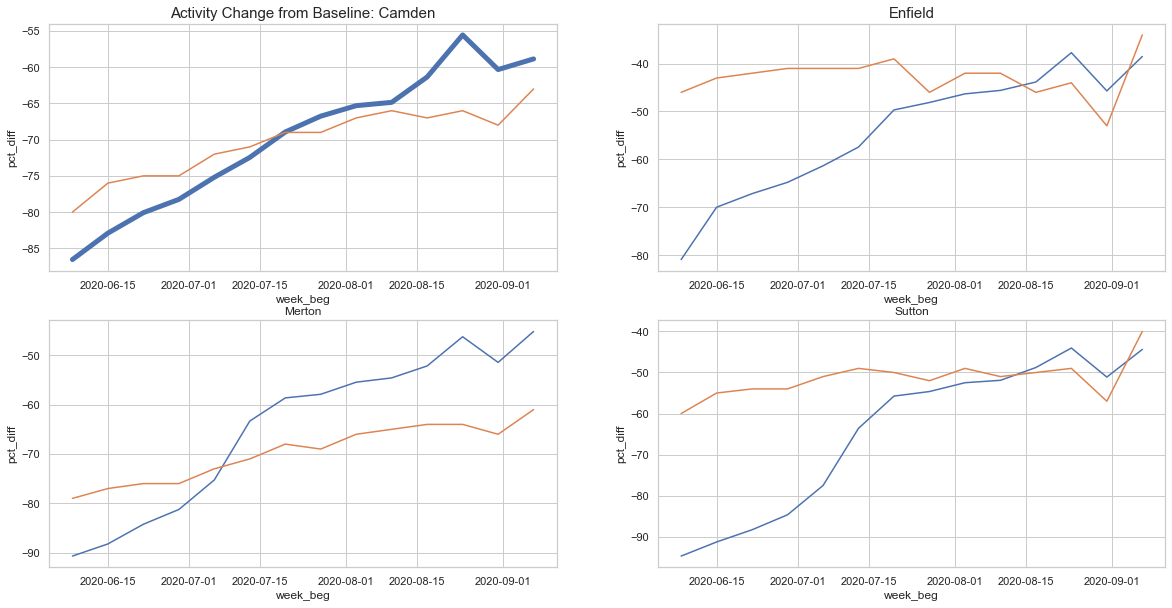

In [8]:
df = pt_laest
#df = df[df['la_name']=='City of London']

fig, ax = plt.subplots(2, 2, figsize=(20, 10), sharex=False, sharey=False)
p = sns.lineplot(x='week_beg', y='pct_diff', data = df[df['la_name']=='Camden'], legend = False, ax=ax[0,0],linewidth=5)
p = sns.lineplot(x='week_beg', y='transit_stations_percent_change_from_baseline', data = df[df['la_name']=='Camden'], legend = False, ax=ax[0,0])

q = sns.lineplot(x='week_beg', y='pct_diff', data = df[df['la_name']=='Enfield'], legend = False, ax=ax[0,1])
q = sns.lineplot(x='week_beg', y='transit_stations_percent_change_from_baseline', data = df[df['la_name']=='Enfield'], legend = False, ax=ax[0,1])

r = sns.lineplot(x='week_beg', y='pct_diff', data = df[df['la_name']=='Merton'], legend = False, ax=ax[1,0])
r = sns.lineplot(x='week_beg', y='transit_stations_percent_change_from_baseline', data = df[df['la_name']=='Hillingdon'], legend = False, ax=ax[1,0])

s = sns.lineplot(x='week_beg', y='pct_diff', data = df[df['la_name']=='Sutton'], legend = True, ax=ax[1,1])
s = sns.lineplot(x='week_beg', y='transit_stations_percent_change_from_baseline', data = df[df['la_name']=='Bromley'], legend = True, ax=ax[1,1])

p.set_title("Activity Change from Baseline: Camden", fontsize = 15)
q.set_title("Enfield", fontsize = 15)
r.set_title("Merton", fontsize = 12)
s.set_title("Sutton", fontsize = 12)

In [9]:
# Calculate weeks from the beginning of the lockdown, this is important for the slope estimates (cannot be against a datetime object)

df = pt_msoaest
df = df[(df['week_beg']>=start_wkbeg)&(df['week_beg']<=end_wkbeg)]
df = df['week_beg'].unique()
df = pd.DataFrame(df)
df.rename(columns = {0:'week_beg'}, inplace = True)

df['weeks'] = 0
df = df.sort_values(by=['week_beg'])

# For loop to calculate number of days in the analysis
for j in range(0, len(df)):
    if (j==0):
        df.iloc[j, len(df.columns)-1] = 0
    else:
        df.iloc[j, len(df.columns)-1] = df.iloc[j-1, len(df.columns)-1] + 1

weeks_map = df
#weeks_map

In [10]:
df = pt_msoaest
df = df[(df['week_beg']>=start_wkbeg)&(df['week_beg']<=end_wkbeg)]
#df = df[df['pct_diff']>=100][['week', 'week_beg', 'msoa_name', 'origin_trips', 'estimate_origin', 'pct_diff']]
df = df[df['subregion']=='Outer South'][['week', 'week_beg', 'msoa_name', 'origin_trips', 'estimate_origin', 'pct_diff']]
df

,week,week_beg,msoa_name,origin_trips,estimate_origin,pct_diff
184113,23,2020-06-08,Bromley 004,"9,760.00","55,211.00",17.68
184114,23,2020-06-08,Bromley 005,"9,450.00","102,909.00",9.18
184115,23,2020-06-08,Bromley 006,"6,973.00","55,691.00",12.52
184116,23,2020-06-08,Bromley 009,"4,504.00","35,086.00",12.84
184117,23,2020-06-08,Bromley 012,"1,140.00","9,523.00",11.97
...,...,...,...,...,...,...
197728,36,2020-09-07,Sutton 022,"3,272.00","6,767.00",48.35
197729,36,2020-09-07,Sutton 024,"2,360.00","4,377.00",53.92
197796,36,2020-09-07,Bromley 040,"6,357.00","12,606.00",50.43
197800,36,2020-09-07,Croydon 045,"1,246.00","1,807.00",68.95


In [11]:
# Tukey Outliers

df = pt_msoaest
df = df[(df['week_beg']>=start_wkbeg)&(df['week_beg']<=end_wkbeg)]

IQR_s = df['pct_diff'].quantile(0.75) - df['pct_diff'].quantile(0.25)
low_s = df['pct_diff'].quantile(0.25) - 1.5*IQR_s
high_s = df['pct_diff'].quantile(0.75) + 1.5*IQR_s

outlier_low_s = df[df['pct_diff'] < low_s]
outlier_high_s = df[df['pct_diff'] > high_s]

outliers = pd.concat([outlier_low_s, outlier_high_s])
msoa_outliers = outliers[['msoa_name']].drop_duplicates()
#msoa_outliers = msoa_outliers.reset_index()
msoa_outliers = list(msoa_outliers['msoa_name'])
msoa_outliers

['Hounslow 025',
 'Redbridge 026',
 'Croydon 016',
 'Croydon 024',
 'Tower Hamlets 020',
 'Hackney 001',
 'Croydon 023',
 'Ealing 039',
 'Lambeth 016',
 'Bromley 001',
 'Hammersmith and Fulham 002']

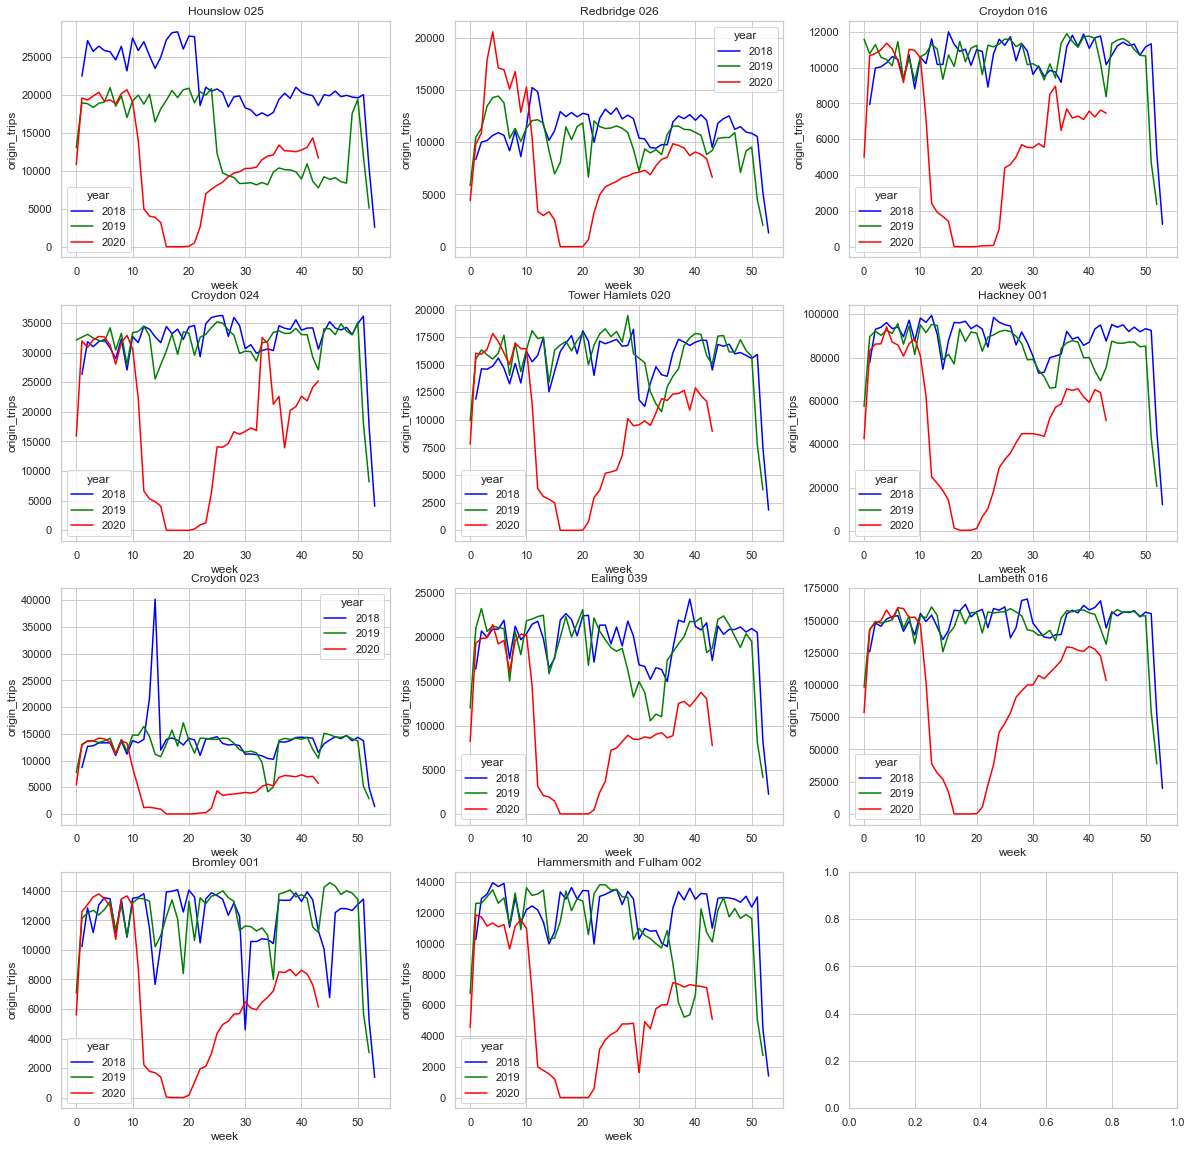

In [12]:
# Analysing all MSOAs to see if the outliers are reasonable.

f, ax = plt.subplots(4,3, figsize=(20, 20))
df = pt_msoaest

tfl_cmap = colors.ListedColormap(['blue', 'green', 'red'])

k = 0

for i in range(0, 4):
    for j in range(0, 3):
        if k <= (len(msoa_outliers)-1):
            p = sns.lineplot(x='week',
                         y='origin_trips',
                         data = df[(df['msoa_name'] == msoa_outliers[k])&(df['year']>=2018)],
                         hue = 'year',
                         legend = True,
                         alpha=1,
                         palette = tfl_cmap,
                         ax = ax[i,j])
            p.set_title(f"{msoa_outliers[k]}", fontsize = 12)
            #sns.histplot(x=plt_cols[k], data = df, ax=ax[i,j], color = 'blue')
            k = k+1

In [13]:
msoa_outliers = ['Hounslow 025']

Text(0.5, 0, 'Week')

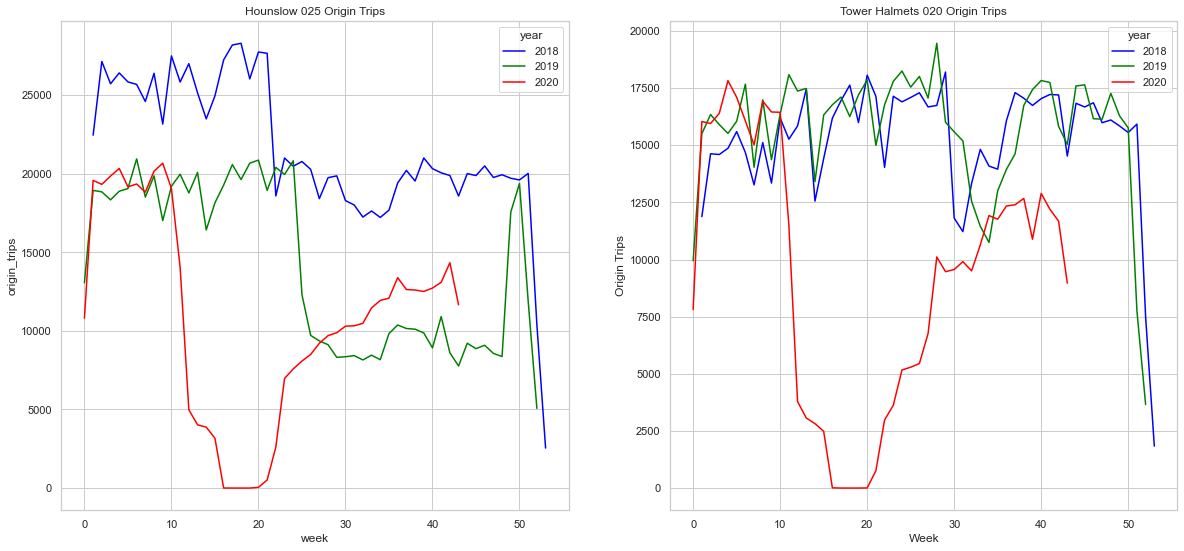

In [14]:
# Outliers Example
sns.set_context('notebook')

f, ax = plt.subplots(1,2, figsize=(20, 9))

tfl_cmap = colors.ListedColormap(['blue', 'green', 'red'])

df = pt_msoaest

p = sns.lineplot(x='week', y='origin_trips', data = df[(df['msoa_name'] == 'Hounslow 025')&(df['year']>=2018)], hue = 'year',
                legend = True,
                alpha=1,
                palette = tfl_cmap,
                ax = ax[0])
q = sns.lineplot(x='week', y='origin_trips', data = df[(df['msoa_name'] == 'Tower Hamlets 020')&(df['year']>=2018)], hue = 'year',
                legend = True,
                alpha=1,
                palette = tfl_cmap,
                ax = ax[1])

p.set_title("Hounslow 025 Origin Trips", fontsize = 12)
q.set_title("Tower Halmets 020 Origin Trips", fontsize = 12)

plt.ylabel("Origin Trips")
plt.xlabel("Week")

Text(0.5, 0, 'Week')

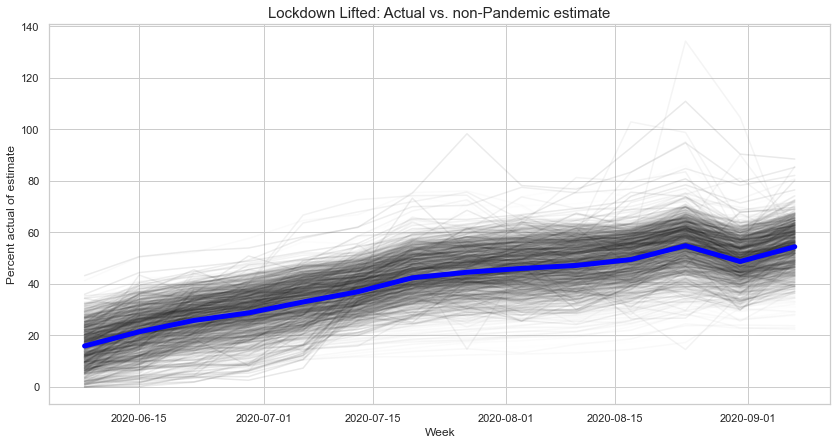

In [15]:
sns.set_context('notebook')

fig, ax = plt.subplots(1, 1, figsize=(14, 7), sharex=False, sharey=False)

df = pt_msoaest
df = df[(df['week_beg']>=start_wkbeg)&(df['week_beg']<=end_wkbeg)]
df = df[~df['msoa_name'].isin(msoa_outliers)]
df2 = df.groupby('week_beg')['pct_diff'].agg('mean').reset_index()


p = sns.lineplot(x='week_beg', y='pct_diff', data = df, hue='msoa_name', legend = False, palette = 'Greys', alpha=0.09)#, ax=ax[0])
q = sns.lineplot(x='week_beg', y='pct_diff', data = df2, legend = False, color = 'blue', dashes = True, linewidth=5)#, size = 500)#, ax=ax[0])
p.set_title("Lockdown Lifted: Actual vs. non-Pandemic estimate", fontsize = 15)
plt.ylabel("Percent actual of estimate")
plt.xlabel("Week")

C:\Users\TBD\.conda\envs\urbsim\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


Text(0.5, 0, 'Week')

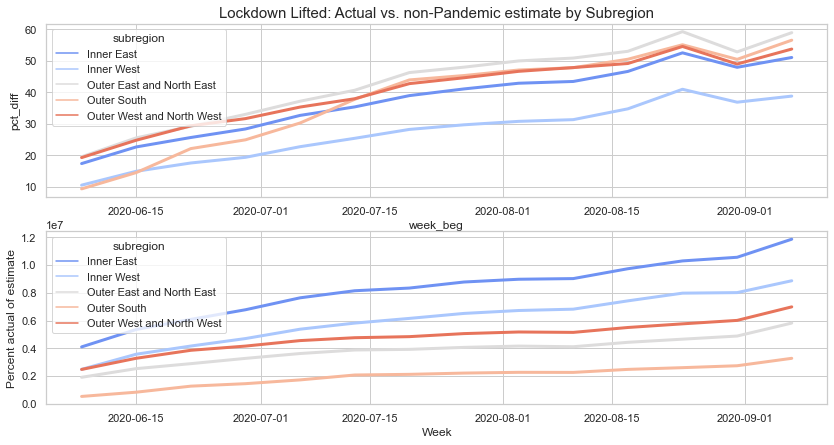

In [16]:
sns.set_context('notebook')

fig, ax = plt.subplots(2, 1, figsize=(14, 7), sharex=False, sharey=False)

df = pt_msoaest
df = df[(df['week_beg']>=start_wkbeg)&(df['week_beg']<=end_wkbeg)]
df = df[~df['msoa_name'].isin(msoa_outliers)]
df = df.groupby(['week_beg', 'subregion'])['origin_trips', 'estimate_origin', 'origin_rail', 'origin_bus'].agg('sum').reset_index()
df['pct_diff'] = (df['origin_trips']/df['estimate_origin'])*100


p = sns.lineplot(x='week_beg', y='pct_diff', data = df, hue='subregion', legend = True, palette = 'coolwarm', ci = None, linewidth = 3, ax=ax[0])
q = sns.lineplot(x='week_beg', y='origin_trips', data = df, hue='subregion', legend = True, palette = 'coolwarm', ci = None, linewidth = 3, ax=ax[1])
p.set_title("Lockdown Lifted: Actual vs. non-Pandemic estimate by Subregion", fontsize = 15)
plt.ylabel("Percent actual of estimate")
plt.xlabel("Week")

[ 3.62733666 20.34449841]


Text(0.5, 1.0, 'Fitted Regression Line')

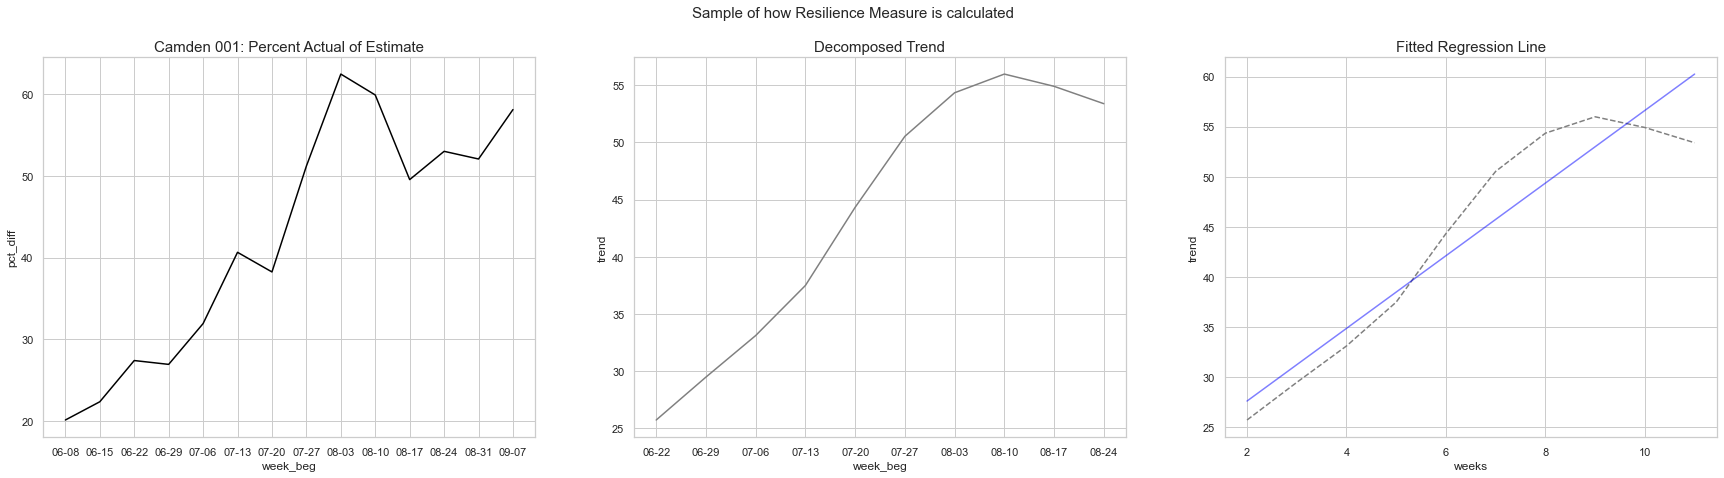

In [17]:
sns.set_context('notebook')

fig, ax = plt.subplots(1, 3, figsize=(30, 7), sharex=False, sharey=False)

df = pt_msoaest
df = df[(df['week_beg']>=start_wkbeg)&(df['week_beg']<=end_wkbeg)]
df = df[~df['msoa_name'].isin(msoa_outliers)]
df = df[df['msoa_name']=='Camden 001']

df_sample = df[['week_beg', 'pct_diff']]
df_sample = df_sample.set_index('week_beg')
decomposition_sample = sm.tsa.seasonal_decompose(df_sample, model = 'additive', period = 4)
df_sample = df_sample.reset_index()
df_sample['week_beg'] = df_sample['week_beg'].dt.strftime('%m-%d')

df_sampletrend = decomposition_sample.trend
df_sampletrend = pd.DataFrame(decomposition_sample.trend[2:len(df_sample)-2])
df_sampletrend = df_sampletrend.reset_index()
df_sampletrend = df_sampletrend.merge(weeks_map, how = 'left', left_on = 'week_beg', right_on = 'week_beg')
df_sampletrend['week_beg'] = df_sampletrend['week_beg'].dt.strftime('%m-%d')
trend = np.array(df_sampletrend['trend'])
weeks = np.array(df_sampletrend['weeks'])

coefficients = np.polyfit(weeks, trend, 1)
print(coefficients)
poly = np.poly1d(coefficients)

new_x = np.linspace(weeks[0], weeks[-1])
new_y = poly(new_x)

df_regression = pd.DataFrame(new_x, new_y)
df_regression = df_regression.reset_index()
df_regression = df_regression.rename({0:'weeks'}, axis=1)

p = sns.lineplot(x='week_beg', y='pct_diff', data = df_sample, color = 'black', legend = False, ax=ax[0])#, palette = 'light:b', alpha=0.5)#, ax=ax[0])
q = sns.lineplot(x='week_beg', y='trend', data = df_sampletrend, color = 'grey', legend = False, ax=ax[1])
r = sns.lineplot(x='weeks', y='trend', data = df_sampletrend, color = 'grey', legend = False, ls='--', ax=ax[2])
s = sns.lineplot(x='weeks', y='index', data = df_regression, color = 'blue', legend = False, alpha = 0.5, ax=ax[2])

fig.suptitle('Sample of how Resilience Measure is calculated', fontsize=15)

p.set_title("Camden 001: Percent Actual of Estimate", fontsize = 15)
#ax0.ylabel("Entries")
#ax0.xlabel("Week")


q.set_title("Decomposed Trend", fontsize = 15)
r.set_title("Fitted Regression Line", fontsize = 15)

[ 1.38261361 48.79197278]


Text(0.5, 1.0, 'Fitted Regression Line')

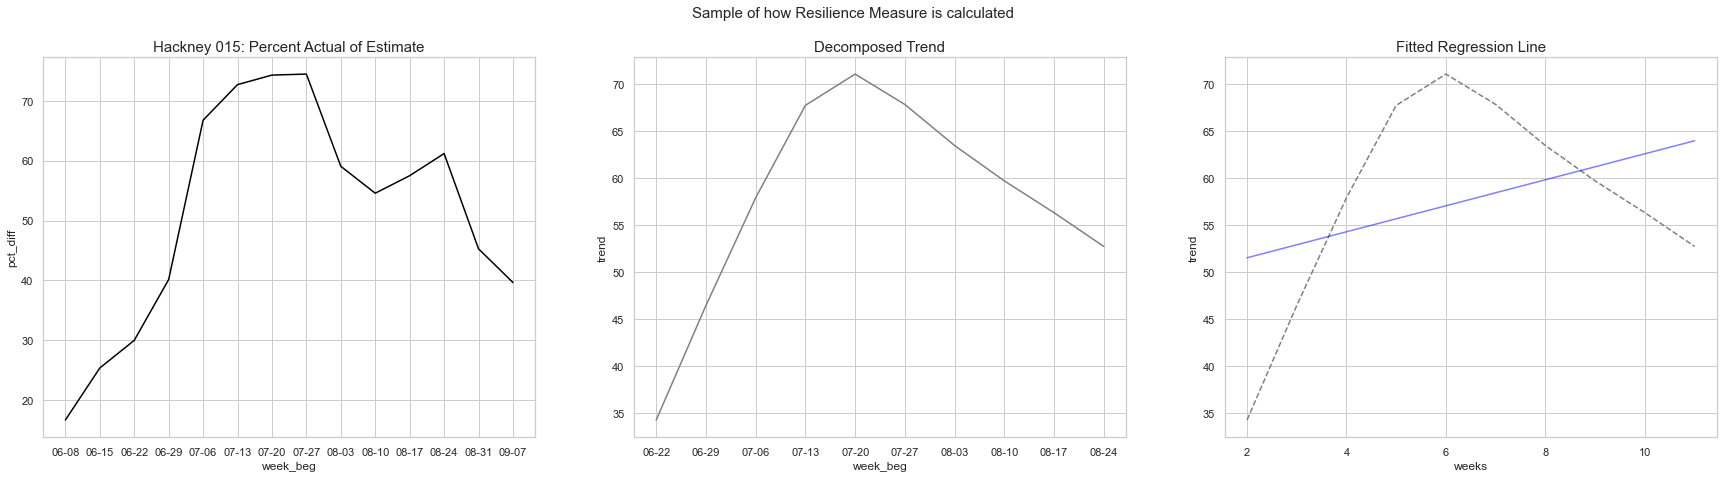

In [18]:
sns.set_context('notebook')

fig, ax = plt.subplots(1, 3, figsize=(30, 7), sharex=False, sharey=False)

df = pt_msoaest
df = df[(df['week_beg']>=start_wkbeg)&(df['week_beg']<=end_wkbeg)]
df = df[~df['msoa_name'].isin(msoa_outliers)]
df = df[df['msoa_name']=='Hackney 015']

df_sample = df[['week_beg', 'pct_diff']]
df_sample = df_sample.set_index('week_beg')
decomposition_sample = sm.tsa.seasonal_decompose(df_sample, model = 'additive', period = 4)
df_sample = df_sample.reset_index()
df_sample['week_beg'] = df_sample['week_beg'].dt.strftime('%m-%d')

df_sampletrend = decomposition_sample.trend
df_sampletrend = pd.DataFrame(decomposition_sample.trend[2:len(df_sample)-2])
df_sampletrend = df_sampletrend.reset_index()
df_sampletrend = df_sampletrend.merge(weeks_map, how = 'left', left_on = 'week_beg', right_on = 'week_beg')
df_sampletrend['week_beg'] = df_sampletrend['week_beg'].dt.strftime('%m-%d')
trend = np.array(df_sampletrend['trend'])
weeks = np.array(df_sampletrend['weeks'])

coefficients = np.polyfit(weeks, trend, 1)
print(coefficients)
poly = np.poly1d(coefficients)

new_x = np.linspace(weeks[0], weeks[-1])
new_y = poly(new_x)

df_regression = pd.DataFrame(new_x, new_y)
df_regression = df_regression.reset_index()
df_regression = df_regression.rename({0:'weeks'}, axis=1)

p = sns.lineplot(x='week_beg', y='pct_diff', data = df_sample, color = 'black', legend = False, ax=ax[0])#, palette = 'light:b', alpha=0.5)#, ax=ax[0])
q = sns.lineplot(x='week_beg', y='trend', data = df_sampletrend, color = 'grey', legend = False, ax=ax[1])
r = sns.lineplot(x='weeks', y='trend', data = df_sampletrend, color = 'grey', legend = False, ls='--', ax=ax[2])
s = sns.lineplot(x='weeks', y='index', data = df_regression, color = 'blue', legend = False, alpha = 0.5, ax=ax[2])

fig.suptitle('Sample of how Resilience Measure is calculated', fontsize=15)

p.set_title("Hackney 015: Percent Actual of Estimate", fontsize = 15)
#ax0.ylabel("Entries")
#ax0.xlabel("Week")


q.set_title("Decomposed Trend", fontsize = 15)
r.set_title("Fitted Regression Line", fontsize = 15)

In [19]:
# Calculate weeks from the beginning of the lockdown, this is important for the slope estimates (cannot be against a datetime object)

df = pt_msoaest
df = df[(df['week_beg']>=start_wkbeg)&(df['week_beg']<=end_wkbeg)]
df = df['week_beg'].unique()
df = pd.DataFrame(df)
df.rename(columns = {0:'week_beg'}, inplace = True)

df['weeks'] = 0
df = df.sort_values(by=['week_beg'])

# For loop to calculate number of days in the analysis
for j in range(0, len(df)):
    if (j==0):
        df.iloc[j, len(df.columns)-1] = 0
    else:
        df.iloc[j, len(df.columns)-1] = df.iloc[j-1, len(df.columns)-1] + 1

weeks_map = df

In [20]:
# Code references:
# how to extract trend from decomposed model: https://mlforanalytics.com/2020/05/29/decomposing-time-series-financial-analytics/

pd.options.display.float_format = '{:,.4f}'.format

df = pt_msoaest
df = df[(df['week_beg']>=start_wkbeg)&(df['week_beg']<=end_wkbeg)]
df = df[~df['msoa_name'].isin(msoa_outliers)]
df = df.groupby(['region', 'subregion', 'msoa_name', 'msoa_code'])['week_beg'].count()
df = pd.DataFrame(df)
df = df.reset_index()
#df = df[df['week_beg']>24]
msoalist = df[['region', 'subregion', 'msoa_name', 'msoa_code']].drop_duplicates()
msoalist = np.array(msoalist)
#print(len(msoalist)-1)


df_slope = []
df_slope = pd.DataFrame(df_slope)
df_slope['region'] = 0
df_slope['subregion'] = 0
df_slope['msoa_name'] = 0
df_slope['msoa_code'] = 0
df_slope['slope'] = 0
#df_slope['pct_change'] = 0
#df_slope['slope2'] = 0
df_decompose = []

# We have an issue where some msoaauth stopped having service in the summer. could be MSOAs with national rail
# stations that were not used until the fall. we're going to drop these as it doesn't make sense to 
# impute the data.

for i in range(0,len(msoalist)):
    #print(msoalist[i][2])
    # Create a dataframe for each local authority
    df = pt_msoaest[pt_msoaest['msoa_name']==msoalist[i][2]]
    df = df[(df['week_beg']>=start_wkbeg)&(df['week_beg']<=end_wkbeg)]
    df = df[['week_beg', 'pct_diff']]
    df = df.set_index('week_beg')
    # Decompose the trend of origin trips
    #decomposition = sm.tsa.seasonal_decompose(df, model = 'additive', extrapolate_trend = 'freq')
    decomposition = sm.tsa.seasonal_decompose(df, model = 'additive', period = 2)#int(len(df)/2))
    df_trend = pd.DataFrame(decomposition.trend[2:len(decomposition.trend)-2]) ## This is critical -- range without NaNs.
    df_trend = df_trend.reset_index()
    df_trend = df_trend.merge(weeks_map, how = 'left', left_on = 'week_beg', right_on = 'week_beg')
    # Create a dataframe of the trend
    # Calculate the slope of the trend
    trend = np.array(df_trend['trend'])
    weeks = np.array(df_trend['weeks'])
    slope,intercept = np.polyfit(weeks, trend, 1)
    # Store the local authority name and slope in a dataframe, total rows should be 33
    df_slope.loc[i,'region'] = msoalist[i][0]
    df_slope.loc[i,'subregion'] = msoalist[i][1]
    df_slope.loc[i,'msoa_name'] = msoalist[i][2]
    df_slope.loc[i,'msoa_code'] = msoalist[i][3]
    df_slope.loc[i,'slope'] = slope

#df_slope
slope_msoa = df_slope
#slope_msoa

In [21]:
# Get geometry back, include Local Authority columns.
df = slope_msoa
df = df.merge(msoas, left_on = ['msoa_code'], right_on = ['MSOA11CD'])
df = gpd.GeoDataFrame(df, crs = 'epsg:27700')
df = df.rename({'LAD11NM':'la_name', 'LAD11CD':'la_code'}, axis=1)
df = df[['region', 'subregion','msoa_name', 'msoa_code', 'slope', 'la_name', 'la_code', 'geometry']]

slope_msoa = df

Text(0.5, 1.0, 'Spatial Plot of Recovery Rate')

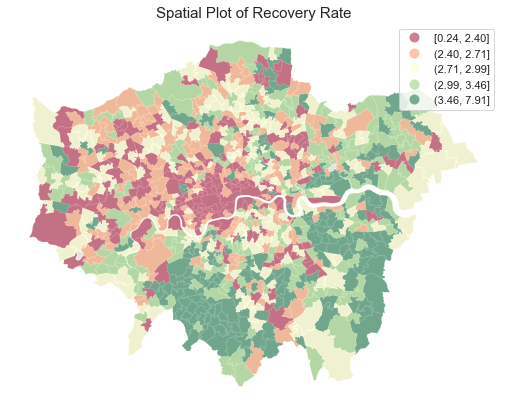

In [22]:
# Plot a chloropeth of slope, code inspired by https://geographicdata.science/book/notebooks/
# We expect to see Central London has the smallest slope -- least likely these areas will have travel demand due to WFH.

sns.set_context('notebook')

f, ax = plt.subplots(1, figsize=(12, 7))

df = slope_msoa

plotmsoa = msoas.plot(ax=ax,alpha=0.8,color='gainsboro')
plotslope = df.plot(column='slope', 
                       cmap='RdYlGn', #Pastel1
                       scheme='quantiles',
                       #k=5, 
                       edgecolor='white', 
                       linewidth=0., 
                       alpha=0.5, 
                       legend=True,
                       #legend_kwds={'fmt':'{:.2f}',"loc": 2},
                       ax=ax
                      )

ax.set_axis_off()
plotslope.set_title("Spatial Plot of Recovery Rate", fontsize = 15)

In [23]:
test = mapclassify.Quantiles(df['slope'], k=5)
test

Quantiles           

  Interval     Count
--------------------
[0.24, 2.40] |   197
(2.40, 2.71] |   196
(2.71, 2.99] |   196
(2.99, 3.46] |   196
(3.46, 7.91] |   196

Text(0.5, 0, 'Recovery Rate')

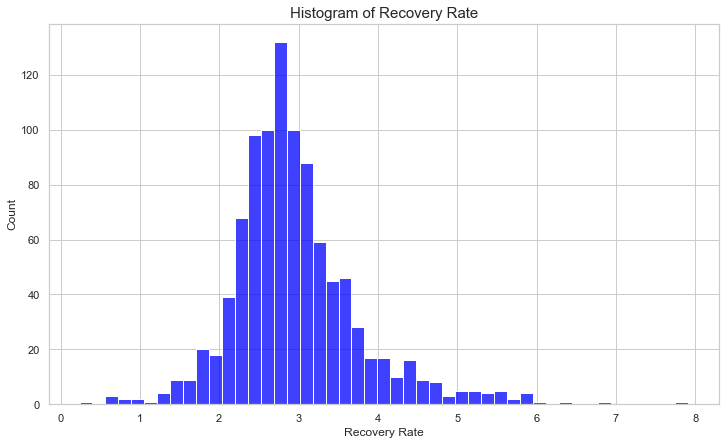

In [25]:
sns.set_context('notebook')

df = slope_msoa

f, ax = plt.subplots(1, figsize=(12, 7))

p = sns.histplot(x='slope', data = df, color = 'blue')
p.set_title("Histogram of Recovery Rate", fontsize = 15)
plt.xlabel("Recovery Rate")

In [26]:
pd.options.display.float_format = '{:,.2f}'.format
df = slope_msoa

df = df.groupby(['region']).describe()
df
#df.pivot(columns = 'slope')

slope                                   
        count mean  std  min  25%  50%  75%  max
region                                          
Inner  395.00 2.74 0.74 0.24 2.37 2.72 3.05 7.91
Outer  586.00 3.10 0.83 0.63 2.55 2.94 3.46 6.92

Text(0.5, 0, 'Recovery Rate')

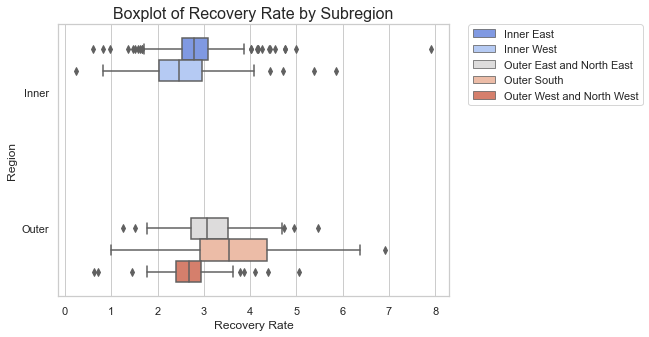

In [27]:
# Distribution by region and subregion
sns.set_context('notebook')
f, ax = plt.subplots(1, figsize=(7, 5))
df = slope_msoa

p = sns.boxplot(x='slope', y = 'region', data = df, hue = 'subregion', palette = 'coolwarm')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
#sns.histplot(x='slope', data = df, hue = 'region')
p.set_title("Boxplot of Recovery Rate by Subregion", fontsize = 16)
plt.ylabel("Region")
plt.xlabel("Recovery Rate")

In [28]:
slope_msoa[slope_msoa['slope']>=7]

,region,subregion,msoa_name,msoa_code,slope,la_name,la_code,geometry
246,Inner,Inner East,Tower Hamlets 020,E02000883,7.91,Tower Hamlets,E09000030,"POLYGON ((537751.837 181672.988, 537771.827 18..."


In [29]:
# Name dataframe
slope_msoa_jun = df

In [30]:
# Save as Shape File
slope_msoa_jun.to_file('output_data/slope_msoa_jun.shp')

In [31]:
len(slope_msoa_jun.index)

981